<a href="https://www.kaggle.com/code/kelixirr/transfer-learning-with-resnetv250-efficientnetb0?scriptVersionId=142375324" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 
    
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close() 

--2023-09-08 20:20:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.9MB/s    in 6.3s    

2023-09-08 20:20:55 (25.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Preparing Data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/" 
test_dir = "10_food_classes_10_percent/test/" 

train_datagen = ImageDataGenerator(rescale = 1/255.) 
test_datagen = ImageDataGenerator(rescale = 1/255.) 

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,\
                                            class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras import layers

In [6]:
# tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1" 

In [8]:
def create_model(model_url, num_classes = 10):
    
    # download the pre_trained model 
    
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable = False,
                                             name = 'feature_extraction_layer',
                                             input_shape = IMAGE_SHAPE+(3,))
    
    # our model 
    model = tf.keras.Sequential([   
        feature_extractor_layer,
        layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
    ])
    
    return model

## ResNetV250

In [13]:
resnet_model = create_model(resnet_url, num_classes = train_data.num_classes)

resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

resnet_history = resnet_model.fit(train_data,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data),
                                 validation_data = test_data,
                                 validation_steps = len(test_data),
                                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230908-205325
Epoch 1/5
24/24 [==============================] - 273s 12s/step - loss: 1.8260 - accuracy: 0.3960 - val_loss: 1.1035 - val_accuracy: 0.6660
Epoch 2/5
24/24 [==============================] - 261s 11s/step - loss: 0.8601 - accuracy: 0.7533 - val_loss: 0.8271 - val_accuracy: 0.7332
Epoch 3/5
24/24 [==============================] - 258s 11s/step - loss: 0.6209 - accuracy: 0.8253 - val_loss: 0.7810 - val_accuracy: 0.7268
Epoch 4/5
24/24 [==============================] - 262s 11s/step - loss: 0.4684 - accuracy: 0.8720 - val_loss: 0.6887 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 254s 11s/step - loss: 0.3694 - accuracy: 0.9160 - val_loss: 0.6835 - val_accuracy: 0.7660


In [39]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # plot loss 
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    #plot accuracy 
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

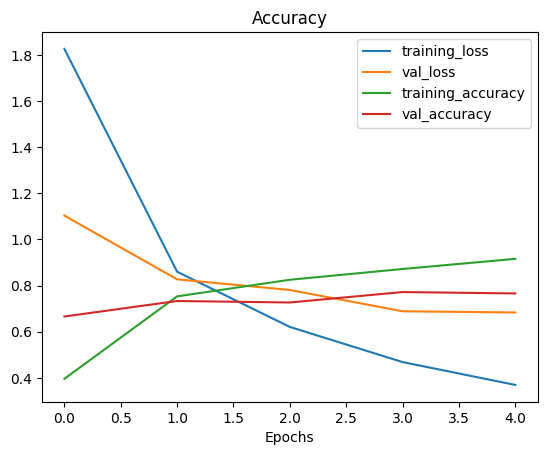

In [40]:
plot_loss_curves(resnet_history)

In [27]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## EfficientNetB0

In [42]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

efficientnet_model.fit(train_data,
                       epochs = 5,
                       steps_per_epoch = len(train_data),
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230908-212810
Epoch 1/5
24/24 [==============================] - 142s 6s/step - loss: 1.9343 - accuracy: 0.3987 - val_loss: 1.3633 - val_accuracy: 0.7328
Epoch 2/5
24/24 [==============================] - 172s 7s/step - loss: 1.1065 - accuracy: 0.7747 - val_loss: 0.8989 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 172s 7s/step - loss: 0.7772 - accuracy: 0.8307 - val_loss: 0.7141 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 172s 7s/step - loss: 0.6208 - accuracy: 0.8733 - val_loss: 0.6236 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 129s 6s/step - loss: 0.5246 - accuracy: 0.8853 - val_loss: 0.5649 - val_accuracy: 0.8612


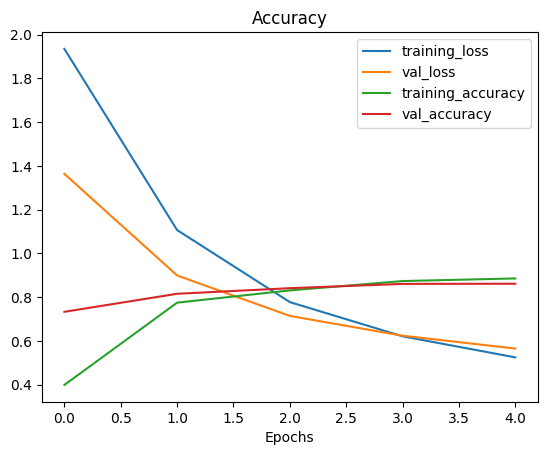

In [44]:
plot_loss_curves(efficientnet_model.history)

In [45]:
efficientnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
